# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
import seaborn as sns
from ast import literal_eval # converts string and converts it to list

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
AZDIAS = pd.read_csv("Udacity_AZDIAS_Subset.csv",delimiter = ';', header =0)
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter = ";", header = 0)

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
AZDIAS.head(5)



,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
def replacing_missing_values_with_NaN(data):
    # X and XX are never used as "real" values, so they can be replaced in the whole data frame in one step
    data.replace(to_replace='XX', value=np.NaN, inplace=True)
    data.replace(to_replace='X', value=np.NaN, inplace=True)

 
    for row in feat_info.itertuples():
        try:
          
            missing_code = eval(row.missing_or_unknown)   
        except NameError:
      
            missing_code = row.missing_or_unknown[1:-1] 
            missing_code = missing_code.split(",") 
            
            if 'X' in missing_code:
                missing_code.remove('X')
            if 'XX' in missing_code:
                missing_code.remove('XX')
        
    
        for missing_item in missing_code:
            data[row.attribute] = data[row.attribute].where(data[row.attribute]!=missing_item, other=np.NaN)
    return data
            
data = replacing_missing_values_with_NaN(AZDIAS)            
display(data.head(n=10))



,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [6]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_values = AZDIAS.isnull().sum()



In [7]:
print("Number of Missing Values is", missing_values.sum())

Number of Missing Values is 8373929


(array([  1.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,  40.,  39.]),
 array([   2160. ,   91066.1,  179972.2,  268878.3,  357784.4,  446690.5,
         535596.6,  624502.7,  713408.8,  802314.9,  891221. ]),
 <a list of 10 Patch objects>)

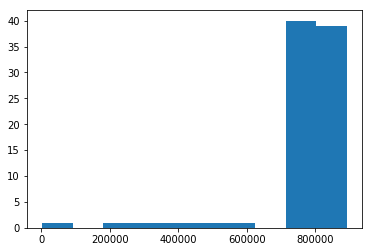

In [8]:
count_data = data.count()
plt.hist(count_data)

In [9]:
# Investigate patterns in the amount of missing data in each column.
print("Variable             |Missing| Total| Missing/Total (in %)\n")
nb_features = data.shape[0]
for column, value in count_data.iteritems():
    print("{:21s}|{:7d}|{}|{}".format(column, value, nb_features, (value/nb_features)*100))


Variable             |Missing| Total| Missing/Total (in %)

AGER_TYP             | 205378|891221|23.044564703928653
ALTERSKATEGORIE_GROB | 888340|891221|99.67673562449718
ANREDE_KZ            | 891221|891221|100.0
CJT_GESAMTTYP        | 886367|891221|99.4553539470008
FINANZ_MINIMALIST    | 891221|891221|100.0
FINANZ_SPARER        | 891221|891221|100.0
FINANZ_VORSORGER     | 891221|891221|100.0
FINANZ_ANLEGER       | 891221|891221|100.0
FINANZ_UNAUFFAELLIGER| 891221|891221|100.0
FINANZ_HAUSBAUER     | 891221|891221|100.0
FINANZTYP            | 891221|891221|100.0
GEBURTSJAHR          | 498903|891221|55.97971771311493
GFK_URLAUBERTYP      | 886367|891221|99.4553539470008
GREEN_AVANTGARDE     | 891221|891221|100.0
HEALTH_TYP           | 780025|891221|87.52318448510526
LP_LEBENSPHASE_FEIN  | 793589|891221|89.04514144078742
LP_LEBENSPHASE_GROB  | 796649|891221|89.3884906212937
LP_FAMILIE_FEIN      | 813429|891221|91.2713008333511
LP_FAMILIE_GROB      | 813429|891221|91.2713008333511
LP_STAT

In [10]:
def REMOVE_OUTLIERS_BY_COLUMONS_F(data, minimum_data_entries = 700000):
    print("Original Shape: ",data.shape)
    count_data = data.count()
    count_data.sort_values(inplace = True)
    keys_few_data = [] 
    for column, value in count_data.iteritems():
        if value < minimum_data_entries:
            print(column, value)
            keys_few_data.append(column)
            data.drop(column, 1, inplace = True)
        else:
            break
            
    data.reset_index(drop = True, inplace =True)
    print("Final Shape: ",data.shape)
    return data, keys_few_data

def REMOVE_OUTLIERS_BY_COLUMONS_U(data, keys_few_data):
    print("Original Shape: ",data.shape) 
    for column in keys_few_data:
        print("<"+column+">")
        data.drop(column, 1, inplace = True)
    
    data.reset_index(drop = True, inplace =True)
    print("Final Shape: ",data.shape)
    return data



In [11]:
minimum_data_entries = 700000
data, keys_few_data = REMOVE_OUTLIERS_BY_COLUMONS_F(data, minimum_data_entries)

Original Shape:  (891221, 85)
TITEL_KZ 2160
AGER_TYP 205378
KK_KUNDENTYP 306609
KBA05_BAUMAX 414697
GEBURTSJAHR 498903
ALTER_HH 580954
Final Shape:  (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

looking at the histogram, gap is at 700K , therefore thats where the data drop was chosen

dropped columons:
TITEL_KZ 2160

AGER_TYP 205378

KK_KUNDENTYP 306609

KBA05_BAUMAX 414697

GEBURTSJAHR 498903

ALTER_HH 580954


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

The Remaining columns:  79
0         36
1         79
2         79
3         72
4         79
5         79
6         79
7         79
8         79
9         79
10        79
11        32
12        73
13        71
14        32
15        71
16        73
17        32
18        76
19        79
20        69
21        79
22        79
23        71
24        32
25        74
26        60
27        79
28        79
29        77
          ..
891191    79
891192    79
891193    79
891194    79
891195    79
891196    79
891197    79
891198    79
891199    79
891200    79
891201    79
891202    79
891203    65
891204    79
891205    79
891206    79
891207    79
891208    76
891209    79
891210    79
891211    79
891212    79
891213    79
891214    79
891215    79
891216    76
891217    75
891218    74
891219    79
891220    79
Length: 891221, dtype: int64


(array([  4.60750000e+04,   2.80380000e+04,   5.03100000e+03,
          1.40160000e+04,   1.55000000e+02,   8.29000000e+02,
          9.53300000e+03,   1.28010000e+04,   7.76340000e+04,
          6.97109000e+05]),
 array([ 30. ,  34.9,  39.8,  44.7,  49.6,  54.5,  59.4,  64.3,  69.2,
         74.1,  79. ]),
 <a list of 10 Patch objects>)

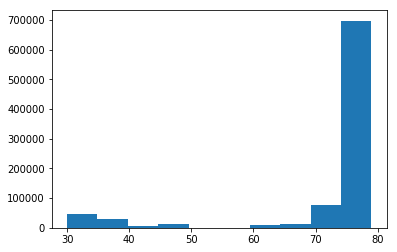

In [12]:
# How much data is missing in each row of the dataset?
all_columns = data.shape[1]
print("The Remaining columns: ",all_columns)
count_rows = data.count(axis = 1)
print(count_rows[:][:])
plt.hist(count_rows)


In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

def REMOVE_OUTLIERS_BY_ROWS(data, minimum_data_entries):
    print(" Default shape of data: {}".format(data.shape))
    rows_below_threshold = data.copy(deep = True)
    rows_above_threshold = data.copy(deep = True)

    keys_below_threshold = []
    keys_above_threshold = []
    
    count_row = data.count(axis = 1)
    count_row.sort_values(inplace = True)

    for key in count_row.keys():

        if count_row.get(key) < limit:
            keys_below_threshold.append(key)
        else:
            keys_above_threshold.append(key)

    rows_above_threshold.drop(keys_below_threshold, inplace = True)
    rows_above_threshold.reset_index(drop = True, inplace =True)
    rows_below_threshold.drop(keys_above_threshold, inplace = True)
    rows_below_threshold.reset_index(drop = True, inplace =True)
    print("{} data rows have been deleted as they contained less than {}  entries. \n"\
          " there are {} rows in total for further computing.".format(rows_below_threshold.shape[0],
                                                                        minimum_data_entries,
                                                                        rows_above_threshold.shape[0]))
    return rows_above_threshold, rows_below_threshold, keys_below_threshold
  
limit = 40 
rows_above_threshold, rows_below_threshold, keys_below_threshold = REMOVE_OUTLIERS_BY_ROWS(data, limit)

 Default shape of data: (891221, 79)
74113 data rows have been deleted as they contained less than 40  entries. 
 there are 817108 rows in total for further computing.


In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
rows_below_threshold.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Discussion 1.1.3: Assess Missing Data in Each Row



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [15]:
# How many features are there of each data type?
print("# of original features per data type: \n{}".format(feat_info.type.value_counts()))
print("# related to the original data without the dropped features!")

def UPDATE_FEAT_INFO(feat_info, keys_few_data):
    feat_info_upd = feat_info.copy(deep=True)
    for key in keys_few_data:
        feat_info_upd = feat_info_upd[feat_info_upd.attribute != key]
    return feat_info_upd

feat_info_upd = UPDATE_FEAT_INFO(feat_info, keys_few_data)
 
print("Number of used features per data type: \n{}".format(feat_info_upd.type.value_counts()))   

# of original features per data type: 
ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64
# related to the original data without the dropped features!
Number of used features per data type: 
ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [16]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
def EXTRACT_COL_TYPES(feat_info):
    ordinal_columns = feat_info_upd[feat_info.type == 'ordinal']
    categorical_columns = feat_info_upd[feat_info.type == 'categorical']
    mixed_columns = feat_info_upd[feat_info.type == 'mixed']
    numeric_columns = feat_info_upd[feat_info.type == 'numeric']
    return ordinal_columns, categorical_columns, mixed_columns, numeric_columns

ordinal_columns, categorical_columns, mixed_columns, numeric_columns = EXTRACT_COL_TYPES(feat_info_upd)
print(ordinal_columns.attribute.shape)
print(categorical_columns.attribute.shape)
print(mixed_columns.attribute.shape)
print(numeric_columns.attribute.shape)
print("#s must be similar to the results of the previous cell!")


(49,)
(18,)
(6,)
(6,)
#s must be similar to the results of the previous cell!


#### Discussion 1.2.1: Re-Encode Categorical Features

i showed which features are binary and which are not in this case Re-encoded the values 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [17]:
def REENCODER_FEAT(data, oridnal_columns, numeric_columns, categorical_columns, mixed_columns):
   
    print("Original shape: {}".format(data.shape))

    for column, value in data.iteritems():
     
        if column in ordinal_columns.attribute.values or column in numeric_columns.attribute.values:
            pass
        elif column in categorical_columns.attribute.values:
            if value.value_counts().shape[0] == 2:
                
                if column == "OST_WEST_KZ":
                    data.replace(to_replace = 'W', value = 1, inplace = True)
                    data.replace(to_replace = 'O', value = 0, inplace = True)
                else:

                    pass
            else:

                    tmp = pd.get_dummies(value, prefix = column)
                    
                    if column == "GEBAEUDETYP" and tmp.shape[1] < 7:
                        # In the customer data there is no column GEBAEUDE_TYP_5.0
                        print("adding Gebauedetyp_5.0, length: ", tmp.shape)
                        additional = {'GEBAEUDETYP_5.0': np.zeros(tmp.shape[1])}
                        additional = pd.DataFrame(data=additional)
                        tmp = pd.concat([tmp,additional], axis = 1)
                    data.drop(column, axis=1, inplace=True)
                    data = pd.concat([data, tmp], axis=1)

        elif column in mixed_columns.attribute.values:
            if column == "CAMEO_INTL_2015":

                wealth = []
                life =[]
                for item in value:
                    if np.isnan(float(item)):
                        wealth.append(np.NaN)
                        life.append(np.NaN)
                    else:
                        wealth.append(int(item[0]))
                        life.append(int(item[1]))
                data.drop(column, axis=1, inplace=True)
                tmp = {'CAMEO_INTL_2015_WEALTH': wealth, 'CAMEO_INTL_2015_LIFE': life}
                tmp = pd.DataFrame(data=tmp)
                data = pd.concat([data, tmp], axis=1)
            elif column == "PRAEGENDE_JUGENDJAHRE":

                avantgarde = []
                generation = []
                for item in value:
                
                    if np.isnan(float(item)):
                        avantgarde.append(np.NaN)
                    elif item in [2,4,6,7,9,11,13,15]:
                        avantgarde.append(1)
                    elif item in [1,3,5,8,10,12,14]:
                        avantgarde.append(0)
                    else:
                        print("MOVEMENT - WRONG LABEL: {}".format(item))
                
                    if np.isnan(float(item)):
                        generation.append(np.NaN)
                    elif item in [1,2]:
                        generation.append(40)
                    elif item in [3,4]:
                        generation.append(50)
                    elif item in [5,6,7]:
                        generation.append(60)
                    elif item in [8,9]:
                        generation.append(70)
                    elif item in [10,11,12,13]:
                        generation.append(80)
                    elif item in [14,15]:
                        generation.append(90)
                    else:
                        print("GENERATION - WRONG LABEL: {}".format(item))
                data.drop(column, axis=1, inplace=True)
                tmp = {'JUGENDJAHRE_AVANTGARDE': avantgarde, 'JUGENDJAHRE_GENERATION': generation}
                tmp = pd.DataFrame(data=tmp)
                data = pd.concat([data, tmp], axis=1)
            
            else:
                data.drop(column, axis=1, inplace=True)
            
        else:
            print("There should be no column in another format: {}".format(column))
    data.reset_index(drop = True, inplace =True)
    print("Shape after adding dummy_variables: {}".format(data.shape))
    return data


data = REENCODER_FEAT(rows_above_threshold, ordinal_columns, numeric_columns, categorical_columns, mixed_columns)



Original shape: (817108, 79)
Shape after adding dummy_variables: (817108, 192)


#### Discussion 1.2.2: Engineer Mixed-Type Features

two mixed-value features are kept :
 
CAMEO_INTL_2015
PRAEGENDE_JUGENDJAHRE

the following steps were taken 

two new feature columns were created , values were copied from intial stage.
two sets were created  to identify the intial feature values to new feature values
then replaced it

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [18]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    data = replacing_missing_values_with_NaN(df)
    
    data = REMOVE_OUTLIERS_BY_COLUMONS_U(data, keys_few_data)
    rows_above_threshold, rows_below_threshold, _ = REMOVE_OUTLIERS_BY_ROWS(data, minimum_data_entries = 32)
    
    feat_info_upd = UPDATE_FEAT_INFO(feat_info, keys_few_data)
    print("Number of used features per data type: \n{}".format(feat_info_upd.type.value_counts()))   
    ordinal_columns, categorical_columns, mixed_columns, numeric_columns = EXTRACT_COL_TYPES(feat_info_upd)
    data_cleaned = REENCODER_FEAT(rows_above_threshold, ordinal_columns, numeric_columns, categorical_columns, mixed_columns)
    few_data_cleaned = REENCODER_FEAT(rows_below_threshold, ordinal_columns, numeric_columns, categorical_columns, mixed_columns)

    return data_cleaned, few_data_cleaned

customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter = ";", header = 0)
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")
clean_customers, customers_below_threshold = clean_data(customers, feat_info)

Original Shape:  (191652, 85)
<TITEL_KZ>
<AGER_TYP>
<KK_KUNDENTYP>
<KBA05_BAUMAX>
<GEBURTSJAHR>
<ALTER_HH>
Final Shape:  (191652, 79)
 Default shape of data: (191652, 79)
46697 data rows have been deleted as they contained less than 32  entries. 
 there are 144955 rows in total for further computing.
Number of used features per data type: 
ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64
Original shape: (144955, 79)
adding Gebauedetyp_5.0, length:  (144955, 6)
Shape after adding dummy_variables: (144955, 192)
Original shape: (46697, 79)
adding Gebauedetyp_5.0, length:  (46697, 0)
Shape after adding dummy_variables: (46697, 131)


In [19]:
#TESTING
data = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter = ";", header = 0)
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")
data, data_below_threshold = clean_data(data, feat_info)

Original Shape:  (891221, 85)
<TITEL_KZ>
<AGER_TYP>
<KK_KUNDENTYP>
<KBA05_BAUMAX>
<GEBURTSJAHR>
<ALTER_HH>
Final Shape:  (891221, 79)
 Default shape of data: (891221, 79)
74113 data rows have been deleted as they contained less than 32  entries. 
 there are 817108 rows in total for further computing.
Number of used features per data type: 
ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64
Original shape: (817108, 79)
Shape after adding dummy_variables: (817108, 192)
Original shape: (74113, 79)
adding Gebauedetyp_5.0, length:  (74113, 0)
Shape after adding dummy_variables: (74113, 131)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [20]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
def SWITCH_NaNs_W_MN(data):
    print("SWITCH_NaNs_W_MN - begin: ",data.shape)
    for column, value in data.iteritems():
        #print(value.to_frame().iloc[:,0].value_counts())
        if value.to_frame().iloc[:,0].isnull().values.any():
            #print("column: {} - empty values", column)
            col_mn = value.to_frame().iloc[:,0].mean()
            data.fillna(col_mn, inplace=True)
    print("SWITCH_NaNs_W_MN - end:" ,data.shape)
    return data
            # NaN values have been replaced by the mean of the column


In [21]:
# Apply feature scaling to the general population demographics data.
def NEW_FEAT_SCALE(data, column_names):
    data = SWITCH_NaNs_W_MN(data)
    scaler = StandardScaler()
    print(data.shape)
    data = scaler.fit_transform(data)
    # data_transformed is a numpy array -> convert it back to a pd.DataFrame
    data_transformed = pd.DataFrame(data,columns=column_names)
    print(data_transformed.shape)
    return data_transformed, scaler


def APPLY_FEAT_SCALE(scaler, data, column_names):
    print(len(column_names))
    data = SWITCH_NaNs_W_MN(data)
    print(data.shape)
    data = scaler.transform(data)
    # data_transformed is a numpy array -> convert it back to a pd.DataFrame
    data_transformed = pd.DataFrame(data,columns=column_names)
    return data_transformed

data_transformed, scaler = NEW_FEAT_SCALE(data, data.columns)
#print(data_transformed.head())
print("aaply_feature_scaling")
tmp = APPLY_FEAT_SCALE(scaler, data, data.columns)


SWITCH_NaNs_W_MN - begin:  (817108, 192)
SWITCH_NaNs_W_MN - end: (817108, 192)
(817108, 192)
(817108, 192)
aaply_feature_scaling
192
SWITCH_NaNs_W_MN - begin:  (817108, 192)
SWITCH_NaNs_W_MN - end: (817108, 192)
(817108, 192)


### Discussion 2.1: Apply Feature Scaling

replaced nan values with mean

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [22]:
# Apply PCA to the data.
pca_all = PCA()
new_pca = pca_all.fit_transform(data_transformed)



In [23]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_25 = PCA(n_components=25)
azdias_p = pca_25.fit_transform(data_transformed)


In [24]:
def scree_ploter(pca):
    n_comp=len(pca.explained_variance_ratio_)
    ind = np.arange(n_comp)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 12))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(n_comp):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance  (%)")
    plt.title('Variance Per Principal Component')

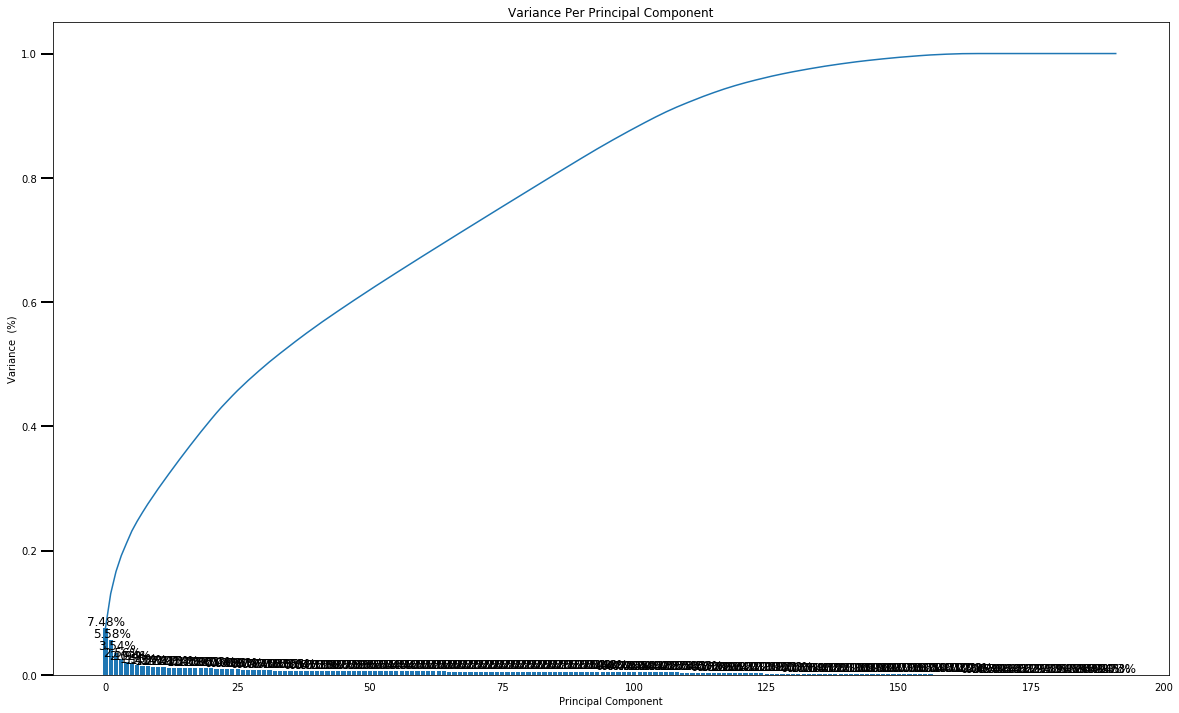

In [25]:
scree_ploter(pca_all)

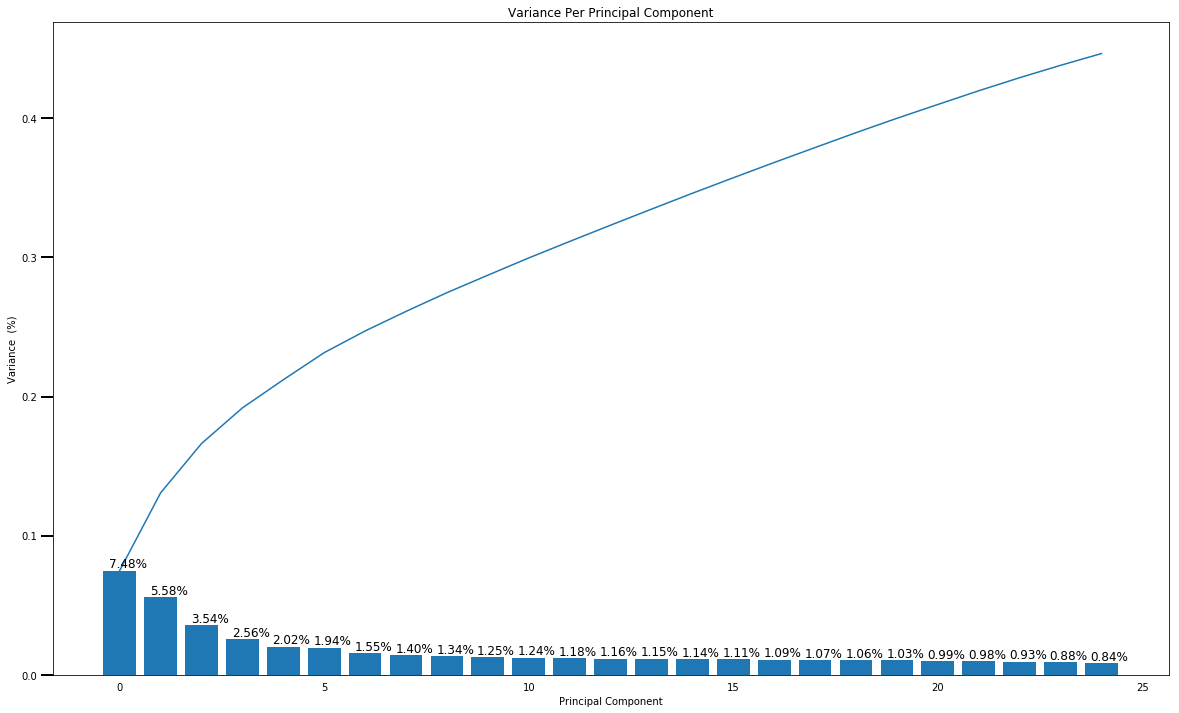

In [26]:
scree_ploter(pca_25)

### Discussion 2.2: Perform Dimensionality Reduction

i've setted 25 principal components, it covers most of the univirse of posiblities 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [27]:
# Map weights for the first principal component to corresponding feature names
def PCA_WI8_2_FEAT(nb_component, full_dataset, pca):

    #indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    #components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    #variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    # concatenated DataFrame
    df_concat = pd.concat([variance_ratios, components], axis = 1)
    linked_values = df_concat.iloc[nb_component-1]
    linked_values_sorted = linked_values.sort_values(inplace = False)
    return linked_values_sorted

PCA_WI8_2_FEAT(1, data_transformed, pca_25)


MOBI_REGIO               -0.2081
FINANZ_MINIMALIST        -0.1967
KBA05_ANTG1              -0.1943
PLZ8_ANTG1               -0.1852
KBA05_GBZ                -0.1826
KONSUMNAEHE              -0.1393
PLZ8_GBZ                 -0.1350
INNENSTADT               -0.1303
CAMEO_INTL_2015_LIFE     -0.1156
LP_STATUS_GROB_4.0       -0.1153
LP_STATUS_FEIN_10.0      -0.1151
LP_STATUS_GROB_5.0       -0.1151
LP_STATUS_FEIN_9.0       -0.1139
GREEN_AVANTGARDE         -0.1033
BALLRAUM                 -0.0994
GEBAEUDETYP_RASTER       -0.0984
ZABEOTYP_1               -0.0974
ALTERSKATEGORIE_GROB     -0.0934
FINANZ_VORSORGER         -0.0916
CAMEO_DEUG_2015_2        -0.0913
GEBAEUDETYP_1.0          -0.0893
ANZ_PERSONEN             -0.0846
FINANZTYP_2              -0.0820
CAMEO_DEUG_2015_4        -0.0743
NATIONALITAET_KZ_1.0     -0.0702
CAMEO_DEUG_2015_3        -0.0674
LP_FAMILIE_GROB_5.0      -0.0667
KBA13_ANZAHL_PKW         -0.0606
SEMIO_LUST               -0.0570
WOHNDAUER_2008           -0.0559
          

In [28]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
PCA_WI8_2_FEAT(1, data_transformed, pca_25)

MOBI_REGIO               -0.2081
FINANZ_MINIMALIST        -0.1967
KBA05_ANTG1              -0.1943
PLZ8_ANTG1               -0.1852
KBA05_GBZ                -0.1826
KONSUMNAEHE              -0.1393
PLZ8_GBZ                 -0.1350
INNENSTADT               -0.1303
CAMEO_INTL_2015_LIFE     -0.1156
LP_STATUS_GROB_4.0       -0.1153
LP_STATUS_FEIN_10.0      -0.1151
LP_STATUS_GROB_5.0       -0.1151
LP_STATUS_FEIN_9.0       -0.1139
GREEN_AVANTGARDE         -0.1033
BALLRAUM                 -0.0994
GEBAEUDETYP_RASTER       -0.0984
ZABEOTYP_1               -0.0974
ALTERSKATEGORIE_GROB     -0.0934
FINANZ_VORSORGER         -0.0916
CAMEO_DEUG_2015_2        -0.0913
GEBAEUDETYP_1.0          -0.0893
ANZ_PERSONEN             -0.0846
FINANZTYP_2              -0.0820
CAMEO_DEUG_2015_4        -0.0743
NATIONALITAET_KZ_1.0     -0.0702
CAMEO_DEUG_2015_3        -0.0674
LP_FAMILIE_GROB_5.0      -0.0667
KBA13_ANZAHL_PKW         -0.0606
SEMIO_LUST               -0.0570
WOHNDAUER_2008           -0.0559
          

In [29]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(PCA_WI8_2_FEAT(2, data_transformed, pca_25))


FINANZ_SPARER            -0.2239
SEMIO_REL                -0.2158
FINANZ_UNAUFFAELLIGER    -0.2122
SEMIO_TRADV              -0.2120
SEMIO_PFLICHT            -0.2036
FINANZ_ANLEGER           -0.2005
JUGENDJAHRE_GENERATION   -0.1846
SEMIO_KULT               -0.1714
ONLINE_AFFINITAET        -0.1673
SEMIO_RAT                -0.1660
SEMIO_FAM                -0.1399
SEMIO_MAT                -0.1313
FINANZTYP_1              -0.1257
ZABEOTYP_4               -0.1052
ZABEOTYP_5               -0.0910
FINANZTYP_4              -0.0896
LP_STATUS_FEIN_2.0       -0.0880
LP_STATUS_FEIN_5.0       -0.0820
FINANZTYP_3              -0.0755
GFK_URLAUBERTYP_9.0      -0.0743
PLZ8_ANTG1               -0.0716
LP_FAMILIE_GROB_4.0      -0.0716
MOBI_REGIO               -0.0700
SEMIO_SOZ                -0.0695
ANZ_PERSONEN             -0.0691
KBA05_ANTG1              -0.0673
KBA05_GBZ                -0.0670
ZABEOTYP_1               -0.0668
CJT_GESAMTTYP_4.0        -0.0560
KONSUMNAEHE              -0.0556
          

### Discussion 2.3: Interpret Principal Components

principal component analysis:

MOBI_REGIO and PLZ8_ANTG3 have a negative correction which means it has higher capacity to move

PLZ8_ANTG3 and PLZ8_ANTG4 have a positive correlation. movement tend to happen along each other

PLZ8_ANTG3 and WEALTH also have a positive correlation. means poorer house holds


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [30]:
def kmeans_score(data, center):
    kmeans = MiniBatchKMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [31]:
nb_clusters = 20 
scores = []
centers = list(range(1,nb_clusters+1))
for center in centers:
    scores.append(kmeans_score(data_transformed, center))



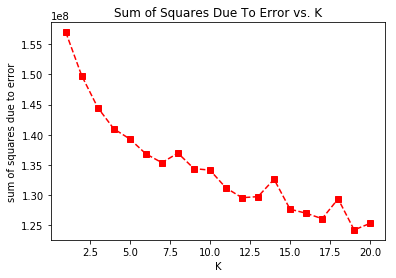

In [32]:
plt.plot(centers, scores, linestyle='--', marker='s', color='r');
plt.xlabel('K');
plt.ylabel('sum of squares due to error');
plt.title('Sum of Squares Due To Error vs. K');
plt.show()

In [33]:
center = 12 #thats when data started to sattle
kmeans_last = MiniBatchKMeans(n_clusters=center)
model = kmeans_last.fit(data_transformed)

predicted_data = model.predict(data_transformed)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [34]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter = ";", header = 0)
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [35]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [36]:
feat_info.head(2)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"


In [37]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

clean_customers, customers_below_threshold = clean_data(customers, feat_info)

print("Shape of clean customers: ", clean_customers.shape)
clean_customers = APPLY_FEAT_SCALE(scaler, clean_customers, clean_customers.columns)
predicted_customers = kmeans_last.predict(clean_customers)
print(predicted_customers)

Original Shape:  (191652, 85)
<TITEL_KZ>
<AGER_TYP>
<KK_KUNDENTYP>
<KBA05_BAUMAX>
<GEBURTSJAHR>
<ALTER_HH>
Final Shape:  (191652, 79)
 Default shape of data: (191652, 79)
46697 data rows have been deleted as they contained less than 32  entries. 
 there are 144955 rows in total for further computing.
Number of used features per data type: 
ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64
Original shape: (144955, 79)
adding Gebauedetyp_5.0, length:  (144955, 6)
Shape after adding dummy_variables: (144955, 192)
Original shape: (46697, 79)
adding Gebauedetyp_5.0, length:  (46697, 0)
Shape after adding dummy_variables: (46697, 131)
Shape of clean customers:  (144955, 192)
192
SWITCH_NaNs_W_MN - begin:  (144955, 192)
SWITCH_NaNs_W_MN - end: (144955, 192)
(144955, 192)
[3 3 6 ..., 3 4 6]


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [38]:
#LEBELING
TEMP = {'LABELS': predicted_data.tolist()}
LABELS_data = pd.DataFrame(data= TEMP)
predicted_data = pd.concat([data, LABELS_data], axis=1)

TEMP = {'LABELS': predicted_customers.tolist()}
LABELS_customers = pd.DataFrame(data=TEMP)
predicted_customers = pd.concat([clean_customers, LABELS_customers], axis=1)


In [41]:
#additional clustering of points
max_LABELS = np.maximum(data_below_threshold.shape[0], customers_below_threshold.shape[0])
LABELS_list=[]
LABELS_list = LABELS_list + [-1]*(max_LABELS - len(LABELS_list))

LABELS_cluster_data_dict = {'LABELS': LABELS_list[:data_below_threshold.shape[0]]}
LABELS_cluster_data = pd.DataFrame(data=LABELS_cluster_data_dict)
print(LABELS_cluster_data)
predicted_data = pd.concat([predicted_data, LABELS_cluster_data], ignore_index=True)

LABELS_cluster_dict = {'LABELS': LABELS_list[:data_below_threshold.shape[0]]}
LABELS_cluster = pd.DataFrame(data=LABELS_cluster_dict)
predicted_customers = pd.concat([predicted_customers, LABELS_cluster], ignore_index=True)


       LABELS
0          -1
1          -1
2          -1
3          -1
4          -1
5          -1
6          -1
7          -1
8          -1
9          -1
10         -1
11         -1
12         -1
13         -1
14         -1
15         -1
16         -1
17         -1
18         -1
19         -1
20         -1
21         -1
22         -1
23         -1
24         -1
25         -1
26         -1
27         -1
28         -1
29         -1
...       ...
74083      -1
74084      -1
74085      -1
74086      -1
74087      -1
74088      -1
74089      -1
74090      -1
74091      -1
74092      -1
74093      -1
74094      -1
74095      -1
74096      -1
74097      -1
74098      -1
74099      -1
74100      -1
74101      -1
74102      -1
74103      -1
74104      -1
74105      -1
74106      -1
74107      -1
74108      -1
74109      -1
74110      -1
74111      -1
74112      -1

[74113 rows x 1 columns]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [43]:
#comparsion
print("Predictive Clustering| Ratio of Data| Ratio of Customers")
cnt_data_LABELS, cnt_data_counts = np.unique(predicted_data.LABELS, return_counts = True)
cnt_customers_LABELS, cnt_customers_counts = np.unique(predicted_customers.LABELS, return_counts = True)


for i in range(-1, center): 
    print("{:17d}|{:13f}|{:18f}".format(i,
                            (cnt_data_counts[i]/predicted_data.shape[0])*100,
                           (cnt_customers_counts[i]/predicted_customers.shape[0])*100))

Predictive Clustering| Ratio of Data| Ratio of Customers
               -1|    12.681927|          9.031442
                0|     8.315895|         33.831048
                1|     0.597046|          0.587489
                2|     2.241195|          2.667208
                3|     9.989105|          1.113809
                4|     9.857263|         24.250918
                5|    12.629752|          7.548341
                6|    11.623380|          0.733562
                7|    14.308348|         14.196962
                8|     0.718453|          0.688371
                9|     6.910632|          3.786496
               10|     1.902222|          0.966823
               11|     8.224784|          0.597531


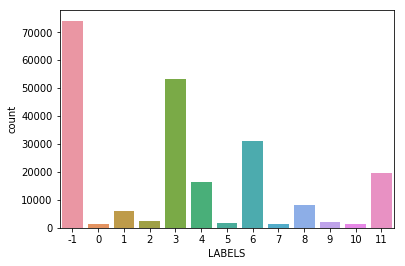

In [44]:
sns.countplot(predicted_customers.LABELS)

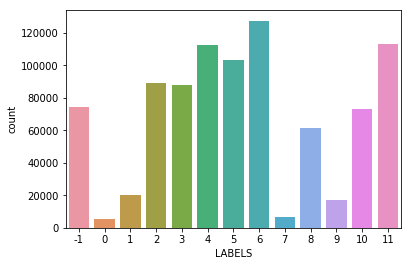

In [45]:
sns.countplot(predicted_data.LABELS)

### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster 5 is mostly influenced by the first principal component which translates to that these people are the opposite. this they are living in lightly built area -less dense-

Cluster 11 is mostly influenced by the second principal component and influced by (HH_EINKOMMEN_SCORE, ORTSGR_KLS9) which is controlled by income

Cluster 4 is mostly influenced by the first principal component ( PLZ8_ANTG3, PLZ8_ANTG4, KBA05_ANTG3,KBA05_ANTG4) : which means they are multi familes live in higher dense areas




> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.